In [1]:
import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.layers import LSTM
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import nltk
from nltk import PorterStemmer

In [3]:
!pip install keras

In [1]:
!pip install snowballstemmer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 3.4 MB/s eta 0:00:00


In [2]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 4.6 MB/s eta 0:00:00
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 59.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 39.8 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 80.7 MB/s eta 0:00:0000:01
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)


In [4]:
!pip install seaborn

  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)


In [2]:
df = pd.read_csv('datasets/labelled_airline_tweet.csv')
df.head()

,Unnamed: 0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,token,topic_no,topic_prob,topic_desc
0,0,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"['aggressive', 'blast', 'obnoxious', 'entertai...",3,0.221675,Reschedule and Refund
1,1,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),[],3,0.214476,Reschedule and Refund
2,2,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),"['seat', 'play', 'fly']",4,0.227286,Phone and Online Booking
3,3,570282469121007616,negative,0.6842,Late Flight,0.3684,Virgin America,NaN,smartwatermelon,NaN,0,@VirginAmerica SFO-PDX schedule is still MIA.,NaN,2015-02-24 10:01:50 -0800,"palo alto, ca",Pacific Time (US & Canada),"['sfopdx', 'schedule']",3,0.259870,Reschedule and Refund
4,4,570276917301137409,negative,1.0000,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,0,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada),"['fully', 'large', 'gentleman']",3,0.193757,Reschedule and Refund


In [3]:
data = df[['topic_desc', 'text']].copy()
data.head()

,topic_desc,text
0,Reschedule and Refund,@VirginAmerica it's really aggressive to blast...
1,Reschedule and Refund,@VirginAmerica and it's a really big bad thing...
2,Phone and Online Booking,@VirginAmerica seriously would pay $30 a fligh...
3,Reschedule and Refund,@VirginAmerica SFO-PDX schedule is still MIA.
4,Reschedule and Refund,@VirginAmerica I flew from NYC to SFO last we...


In [4]:
pd.set_option('display.max_colwidth', 1)
data.sample(5)

,topic_desc,text
7913,Reschedule and Refund,"@AmericanAir your a LIAR, no precipitation all day, 47 degrees, don't pacify, you look like a fool.......thats the problem, admit you suck"
2281,Reschedule and Refund,@united oh flight was fine. my lost luggage? not so much. looks like I'll be at least a half day Late Flight to my conference in Santa Monica...
7048,Reschedule and Refund,@USAirways been delayed three times now finally boarded. Been waiting 20 minutes. Now being told the plan has to be completely powered down.
7567,Baggage Issue,".@AmericanAir Alright prove it: (1/3) 3 days ago, I sat on a plane at JFK for 3 hrs, deplaned for 3 more, and when I re-boarded..."
7445,Baggage Issue,"@AmericanAir To announce DURING BOARDING that you chose to limit catering to the point that you WILL run out shows a lack of planning, IMO."


In [5]:
data['topic_desc'].value_counts()

topic_desc
Reschedule and Refund         6512
Baggage Issue                 1513
Phone and Online Booking      421 
Extra Charges                 268 
Delay and Customer Service    223 
Seating Preferences           153 
Reservation Issue             78  
Customer Experience           10  
Name: count, dtype: int64

In [6]:
def print_plot(index):
    example = df[df.index == index][['text','topic_desc']].values[0]
    if len(example) > 0 and example is not None:
        print(example[0])
        print('Greivance type:', example[1])
print_plot(10)

@VirginAmerica hi! I just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during Flight Booking Problems 😢
Greivance type: Reservation Issue


In [7]:
#Text Preprocessing
import re

def clean_text(txt):
    
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
    txt = txt.lower()
    txt = re.sub(r"(?<=\w)nt", "not",txt) #change don't to do not cna't to cannot 
    txt = re.sub(r"(@\S+)", "", txt)  # remove hashtags
    txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
    txt = txt.translate(str.maketrans('', '', string.punctuation)) # remove punctuations 
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters (it's -> it s then we need to remove s)
    txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
    txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
    txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stopwords.words('english') ]) # stem & remove stop words
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
    return txt


In [8]:
print('Original Text : ',data['text'][5])  
print('Processed Text : ',clean_text(data['text'][5]))

Original Text :  @VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???
Processed Text :  first fare may three time carrier seat avail select


In [9]:
data['text'] = data['text'].apply(clean_text)
data['text'].values

array(['realli aggress blast obnoxi enotertainmenot guest face amp littl recours',
       'realli big bad thing',
       'serious would pay  flight seat play realli bad thing fli va', ...,
       'right cue delay',
       'leav  minut late flight warn commun unotil  minut late flight call shitti custom svc',
       'money chang flight answer phone suggest make commitmenot'],
      dtype=object)

In [10]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11306 unique tokens.


In [11]:
# Word Embedding
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape[1])

Shape of data tensor: 250


In [12]:
#Converting categorical labels to numbers.
Y = pd.get_dummies(df['topic_desc']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (9178, 8)


In [13]:
#Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8260, 250) (8260, 8)
(918, 250) (918, 8)


In [29]:
# Model Structuring
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/10


2023-12-27 15:06:18.278236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 18723s 160s/step - loss: 1.0608 - accuracy: 0.7031 - val_loss: 0.9765 - val_accuracy: 0.7119
Epoch 2/10
117/117 [==============================] - 18746s 160s/step - loss: 0.8400 - accuracy: 0.7355 - val_loss: 0.8986 - val_accuracy: 0.7143
Epoch 3/10
117/117 [==============================] - 17678s 151s/step - loss: 0.6003 - accuracy: 0.8154 - val_loss: 0.8264 - val_accuracy: 0.7470
Epoch 4/10
117/117 [==============================] - 16335s 140s/step - loss: 0.4331 - accuracy: 0.8678 - val_loss: 0.7483 - val_accuracy: 0.7797
Epoch 5/10
117/117 [==============================] - 18361s 157s/step - loss: 0.3300 - accuracy: 0.8953 - val_loss: 0.7689 - val_accuracy: 0.7615
Epoch 6/10
117/117 [==============================] - 17785s 152s/step - loss: 0.2230 - accuracy: 0.9337 - val_loss: 0.8071 - val_accuracy: 0.7663
Epoch 7/10
117/117 [==============================] - 22547s 193s/step - loss: 0.1579 - accuracy: 0.9516 - val_loss: 0.8571 - val

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 250, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
Total params: 5081208 (19.38 MB)
Trainable params: 5081208 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
import pickle

model.save_weights("models/multiclassComplaintClassifier.h5")

with open("models/tokenizerMulticlassComplaintClassification.pickle", 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
#Accuracy
acr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acr[0],acr[1]))

29/29 [==============================] - 108s 4s/step - loss: 0.7662 - accuracy: 0.8105
Test set
  Loss: 0.766
  Accuracy: 0.810


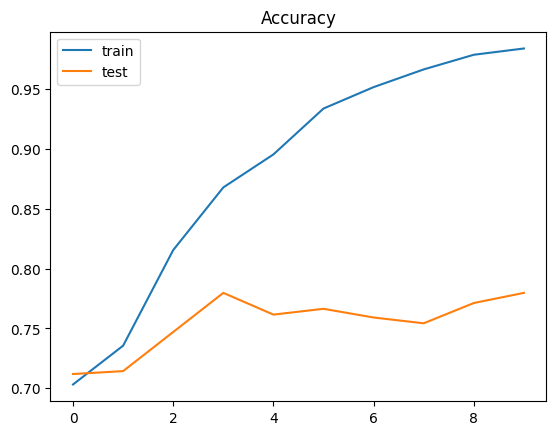

In [35]:
#Accuracy Plot
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [36]:
# Test a new complaint
new_tweet = ['is todays flight from Palm Springs Ca to JFK in NY Cancelled Flightled']
seq = tokenizer.texts_to_sequences(new_tweet)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Reschedule and Refund', 'Baggage Issue','Phone and Online Booking', 'Extra Charges', 'Delay and Customer Service', 'Seating Preferences', 'Reservation Issue', 'Customer Experience']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 4s 4s/step
[[7.83448922e-05 1.09546345e-05 6.39173959e-05 3.35860459e-05
  3.22521024e-04 9.99309421e-01 6.09204744e-06 1.75163557e-04]] Seating Preferences


In [15]:
class MulticlassComplainInference:

  def __init__(self):
      self.load_models()

  def get_model(self):
      model = Sequential()
      model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
      model.add(SpatialDropout1D(0.2))
      model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
      model.add(Dense(8, activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      return model
  
  
  def load_models(self):
      with open('models/tokenizerMulticlassComplaintClassification.pickle', 'rb') as handle:
          self.tokenizer = pickle.load(handle)

      self.model = self.get_model()
      self.model.load_weights("models/multiclassComplaintClassifier.h5")

  def clean_text(self, txt):
    
      """
      removing all hashtags , punctuations, stop_words  and links, also stemming words 
      """
      txt = txt.lower()
      txt = re.sub(r"(?<=\w)nt", "not",txt) #change don't to do not cna't to cannot 
      txt = re.sub(r"(@\S+)", "", txt)  # remove hashtags
      txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
      txt = txt.translate(str.maketrans('', '', string.punctuation)) # remove punctuations 
      txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters (it's -> it s then we need to remove s)
      txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
      txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
      txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stopwords.words('english') ]) # stem & remove stop words
      txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
      return txt
  
  def predict_complaint(self, text):
      new_tweet = self.clean_text(text)
      seq = self.tokenizer.texts_to_sequences([new_tweet])
      padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
      pred = self.model.predict(padded)
      labels = ['Reschedule and Refund', 'Baggage Issue','Phone and Online Booking', 'Extra Charges', 
                'Delay and Customer Service', 'Seating Preferences', 'Reservation Issue', 'Customer Experience']
      print(pred, labels[np.argmax(pred)])
      return labels[np.argmax(pred)]


In [16]:
mul = MulticlassComplainInference()

2024-01-03 15:56:05.353229: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-03 15:56:05.353521: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-03 15:56:05.353543: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-03 15:56:05.353616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-03 15:56:05.353651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
mul.predict_complaint("@united I have never been mislead by a company as many times as I have this week by United Airlines!")

2024-01-03 15:56:17.316230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 6s 6s/step
[[1.0888101e-04 4.1318763e-05 5.0885850e-05 1.1628529e-04 5.9241203e-05
  9.9938738e-01 9.9492108e-06 2.2603710e-04]] Seating Preferences


'Seating Preferences'